# Fit statistical models to N<sub>2</sub>O and CH<sub>4</sub> data

Models are

**Simple model**
$$
\ln{F_{i,k}} = \alpha_k + \beta_k\frac{T_{i,j} - 10^{\circ} \text{C}}{10^{\circ} \text{C}} \\
i = 1 \ldots \text{\# observations} \\
k \in \left[  \mathrm{N_2O} ; \mathrm{CH_4} \right] \\
T_i = \text{ Observed air temperature (K)}
$$

**Full model**
$$
\ln{F_{i,k}} = \alpha_k + \beta_k f(T_{i}) + \sum_{j=1}^{N} \gamma_{j,k}x_{i,j} + \delta_{j,k} x_{i,j} f(T_{i}) \\

f(T_{i}) = \frac{T_{i,j} - 10^{\circ} \text{C}}{10^{\circ} \text{C}}
$$

Each model is run with 9, 5 and 3 surface types

In [1]:
import pandas as pd
from dotenv import load_dotenv; load_dotenv()
from datetime import datetime, timedelta
import os

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib as mpl
import xarray as xr

from utils import load_Ran_ec_data, load_Ran_biomet_data

from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.special import gamma

from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pymc as pm
import arviz as az

import pickle
import cloudpickle

%matplotlib widget
%load_ext autoreload
%autoreload 2

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Define model functions

In [2]:
def simple_model(T, y, alpha_mean, alpha_std, lambda_beta=1.0, lambda_epsilon=1.0):
    with pm.Model() as model:
        alpha = pm.Normal('alpha', mu=alpha_mean, sigma=alpha_std)
        beta = pm.Exponential('beta', lambda_beta)
        epsilon = pm.Exponential("sigma", lambda_epsilon)

        T = pm.MutableData("T_air", T)

        mu = alpha + beta*(T-10)/10

        y = pm.Normal("obs", mu=mu, sigma=epsilon, observed=y)

        idata = pm.sample_prior_predictive(samples=2000)

    return model, idata

In [3]:
simple_model_eq = lambda T,params,inds: params['alpha'] + params['beta']*((T[inds]-10)/10)

In [4]:
def full_model(T,X,y, alpha_mu_mean, alpha_mu_std, gamma_std=2.0, lambda_beta=1.0, lambda_delta=1.0, lambda_epsilon=1.0):
    coords = {'st': X.columns.to_list(), 'obs_id': np.arange(y.shape[0])}
    with pm.Model(coords_mutable=coords) as model:
        alpha = pm.Normal("alpha", mu=alpha_mu_mean, sigma=alpha_mu_std)
        beta = pm.Exponential('beta', lambda_beta)

        gamma_mu = pm.Normal("gamma_mu", mu=0, sigma=1)
        gamma = pm.Normal("gamma", mu=gamma_mu, sigma=gamma_std, dims='st')

        delta = pm.Exponential("delta", lambda_delta, dims='st')

        epsilon = pm.Exponential("sigma", lambda_epsilon)

        T = pm.MutableData("T_air", np.repeat(T.reshape(T.shape[0],1), repeats=len(coords['st']), axis=1), dims=("obs_id","st"))
        ST = pm.MutableData("ST", X.values, dims=("obs_id", "st"))

        mu = alpha + beta*(T[:,0]-10)/10  + pm.math.sum(gamma*ST + delta*(T-10)/10*ST, axis=1)

        y = pm.Normal("obs", mu=mu, sigma=epsilon, observed=y)

        idata = pm.sample_prior_predictive(samples=2000)

    return model, idata

In [5]:
full_model_eq = lambda T,X,params,inds: params['alpha'] + params['beta']*((T[inds, 0]-10)/10) + np.sum(params['gamma']*X[inds, :] + params['delta']*((T[inds, :]-10)/10)*X[inds, :],axis=1)

In [6]:
def fit_model(model, draws=2000, tune=2000, chains=4):
    with model:
        model_res = pm.sample(draws, tune=tune, chains=chains)

    return model_res

# Define visualization functions

In [24]:
def visualize_fit(model, obs, prior_values, posterior, xlabel, ylabel, color_var=None, cb_label='', axs=None):
    # NB! These works only for negative values of model and obs
    # Figure definitions
    if axs is None:
        fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
        axs = axs.flatten()
        fig.subplots_adjust(bottom=0.2, hspace=0.3, wspace=0.3)
    fs=14
    ls=10


    # Find min and max value between model and measurements

    if np.min(model) < model.min():
        min_all = np.min(model)
    else:
        min_all = obs.min()
    min_all = min_all*1.15

    if np.max(model) > model.max():
        max_all = np.max(model)
    else:
        max_all = obs.max()
    max_all = max_all*1.15

    # Fig. 1
    bins, counts, _ = axs[0].hist(obs, bins=100, color='goldenrod', density=True, label=f'Measured {xlabel}')
    bins, counts, _ = axs[0].hist(prior_values, bins = np.linspace(-10,10,201), alpha=0.75, density=True, label='Prior')

    axs[0].legend(loc='best')
    axs[0].set_xlabel(xlabel, fontsize=fs)
    axs[0].tick_params(axis='both', labelsize=ls)

    # Fig. 2
    az.plot_ppc(posterior, num_pp_samples=300, ax=axs[1])
    axs[1].set_xlabel(xlabel, fontsize=fs)
    axs[1].tick_params(axis='both', labelsize=ls)

    # Fig. 3
    axs[2].plot(obs.index, obs, 'o', markersize=4, markeredgecolor='k', markeredgewidth=0.5, color='w', label='Measured')
    axs[2].plot(obs.index, model, 'o', color='b', markeredgecolor='k', markeredgewidth=0.5, markersize=4, label='MAP estimate', alpha=.50)

    axs[2].set_ylabel(ylabel, fontsize=fs)

    axs[2].tick_params(axis='both', labelsize=ls)
    axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
    axs[2].legend(loc='best', prop={'size': ls})

    # Fig. 4
    r2 = r2_score(obs.values, model)
    rmse = mean_squared_error(obs.values, model)
    if color_var is not None:
        im = axs[3].scatter(model, obs, c=color_var, s=3)
        cb = fig.colorbar(im)
        cb.set_label('T$_{\mathrm{air}}$ ($^{\circ}$C)', fontsize=fs)
        cb.ax.tick_params(labelsize=fs-1)
    else:
        im = axs[3].scatter(model, obs, c='gray', s=3)

    axs[3].set_xlabel(f'Modelled {ylabel}', fontsize=fs)
    axs[3].set_ylabel(f'Measured {xlabel}', fontsize=fs)
    axs[3].tick_params(axis='both', labelsize=ls)
    axs[3].text(min_all*0.95, max_all*0.8, f'R$^2$ = {np.round(r2, 2)}', fontsize=ls)

    axs[3].text(min_all*0.95, max_all*0.7, f'RMSE = {np.round(rmse, 5)}', fontsize=ls)
    axs[3].set_xlim(min_all, max_all)
    axs[3].set_ylim(min_all, max_all)
    axs[3].plot((-15,15), (-15,15), 'k--', linewidth=2)

# Load data

In [8]:
data_n2o = pd.read_csv('data/inference_data_n2o.csv', index_col='time')
data_n2o.index = pd.to_datetime(data_n2o.index)

data_ch4 = pd.read_csv('data/inference_data_ch4.csv', index_col='time')
data_ch4.index = pd.to_datetime(data_ch4.index)

In [9]:
# For CH4 remove the two datapoint ln(CH4) ~= -7.1 & -4.4 as this makes produces warning in model comparison stage

# data_ch4 = data_ch4.loc[data_ch4.F_CH4_ln > -4.1, :]

# Define surface type dataframes

In [10]:
st_3_n2o = data_n2o.loc[:, ['Exposed peat','All ditches','Residue, ground and vegetation']]
st_5_n2o = data_n2o.loc[:, ['Exposed peat','All ditches','Logging residue','Light moss','Green vegetation and trees']]
st_9_n2o = data_n2o.loc[:, ['Fallen tree', 'Dry branch', 'Exposed peat', 'Light moss', 'Dark moss', 'Green vegetation', 'Ditch', 'Tree', 'Covered ditch',]]
st_6_n2o = data_n2o.loc[:, ['Exposed peat','Ditch','Covered ditch','Logging residue','Light moss','Green vegetation and trees']]
st_4_n2o = data_n2o.loc[:, ['Exposed peat','Ditch','Covered ditch','Residue, ground and vegetation']]

In [11]:
st_3_ch4 = data_ch4.loc[:, ['Exposed peat','All ditches','Residue, ground and vegetation']]
st_5_ch4 = data_ch4.loc[:, ['Exposed peat','All ditches','Logging residue','Light moss','Green vegetation and trees']]
st_9_ch4 = data_ch4.loc[:, ['Fallen tree', 'Dry branch', 'Exposed peat', 'Light moss', 'Dark moss', 'Green vegetation', 'Ditch', 'Tree', 'Covered ditch',]]
st_6_ch4 = data_ch4.loc[:, ['Exposed peat','Ditch','Covered ditch','Logging residue','Light moss','Green vegetation and trees']]
st_4_ch4 = data_ch4.loc[:, ['Exposed peat','Ditch','Covered ditch','Residue, ground and vegetation']]

# N<sub>2</sub>O models

## $\alpha$ prior parameters

In [12]:
ind = ((data_n2o.T_air <= 11) & (data_n2o.T_air_K >= 9))
n2o_tenC_mean, n2o_tenC_std = ((data_n2o.loc[ind, 'F_N2O_ln']).mean(), (data_n2o.loc[ind, 'F_N2O_ln']).std())

## N<sub>2</sub>O simple model

In [13]:
simple_n2o, idata_simple_n2o = simple_model(T=data_n2o.T_air.values, y=data_n2o.F_N2O_ln.values, alpha_mean=n2o_tenC_mean, alpha_std=n2o_tenC_std)

Sampling: [alpha, beta, obs, sigma]


In [14]:
simple_n2o_res = fit_model(simple_n2o)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.


In [15]:
with simple_n2o:
        map_estimate_simple, optresult = pm.find_MAP(method="L-BFGS-B", return_raw=True
    )

In [16]:
with simple_n2o:
    pm.sample_posterior_predictive(simple_n2o_res, extend_inferencedata=True)

Sampling: [obs]


/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


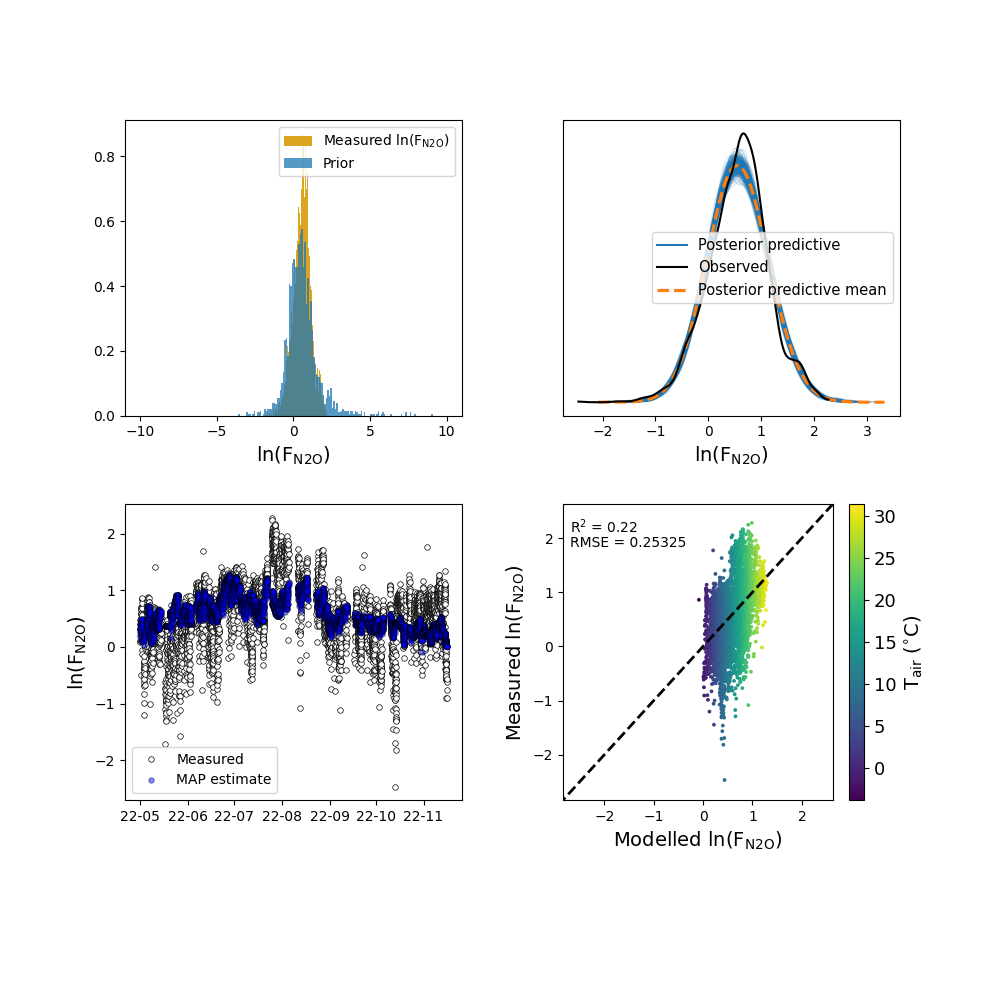

In [25]:
model = simple_model_eq(simple_n2o['T_air'].eval(), map_estimate_simple, np.arange(data_n2o.shape[0]))
obs = data_n2o.loc[:, 'F_N2O_ln']

prior = idata_simple_n2o['prior']
data_inds = np.random.choice(simple_n2o['T_air'].eval().shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = simple_model_eq(simple_n2o['T_air'].eval(), pp, data_inds)

posterior = simple_n2o_res

xlabel = 'ln(F$_{\mathrm{N2O}}$)'
ylabel = 'ln(F$_{\mathrm{N2O}}$)'

color_var = data_n2o.T_air.values
cb_label = 'T$_{\mathrm{air}}$ ($^{\circ}$C)'

visualize_fit(model, obs, prior_values, posterior, xlabel, ylabel, color_var=color_var, cb_label=cb_label, axs=None)

In [26]:
fname = 'models/simple_model_n2o_mutable.pkl'
dict_to_save = {'model': simple_n2o,
                'idata': idata_simple_n2o,
                'model_res': simple_n2o_res,
                'map': map_estimate_simple,
                'data': data_n2o
                }

with open(fname, 'wb') as buff:
    cloudpickle.dump(dict_to_save, buff)

## N<sub>2</sub>O full model

### 3 surface types

In [27]:
full_n2o_st3, idata_full_n2o_st3 = full_model(T=data_n2o.T_air.values, X=st_3_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std)

Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]


In [28]:
full_n2o_st3_res = fit_model(full_n2o_st3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma_mu, gamma, delta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 648 seconds.


In [29]:
with full_n2o_st3:
        map_estimate_st3, optresult = pm.find_MAP(method="L-BFGS-B", return_raw=True
    )

In [30]:
with full_n2o_st3:
    pm.sample_posterior_predictive(full_n2o_st3_res, extend_inferencedata=True)

Sampling: [obs]


/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


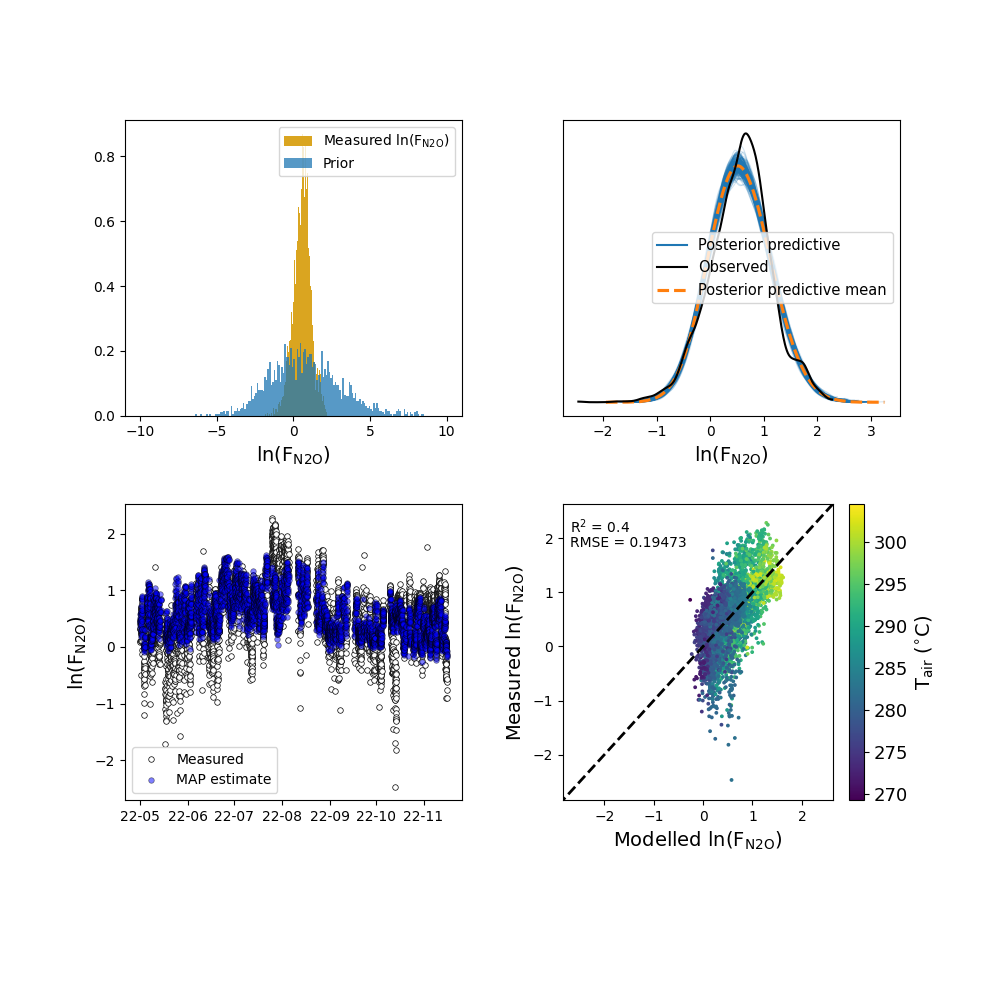

In [31]:
model = full_model_eq(full_n2o_st3['T_air'].eval(), st_3_n2o.values, map_estimate_st3, np.arange(data_n2o.shape[0]))
obs = data_n2o.loc[:, 'F_N2O_ln']

prior = idata_full_n2o_st3['prior']
data_inds = np.random.choice(st_3_n2o.shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = full_model_eq(full_n2o_st3['T_air'].eval(), st_3_n2o.values, pp, data_inds)

posterior = full_n2o_st3_res

xlabel = 'ln(F$_{\mathrm{N2O}}$)'
ylabel = 'ln(F$_{\mathrm{N2O}}$)'

color_var = data_n2o.T_air_K.values
cb_label = 'T$_{\mathrm{air}}$ (K)'

visualize_fit(model, obs, prior_values, posterior, xlabel, ylabel, color_var=color_var, cb_label=cb_label, axs=None)

In [32]:
fname = 'models/full_model_n2o_st3_mutable.pkl'
dict_to_save = {'model': full_n2o_st3,
                'idata': idata_full_n2o_st3,
                'model_res': full_n2o_st3_res,
                'map': map_estimate_st3,
                'data': data_n2o
                }

with open(fname, 'wb') as buff:
    cloudpickle.dump(dict_to_save, buff)

### 4 surface types

In [33]:
full_n2o_st4, idata_full_n2o_st4 = full_model(T=data_n2o.T_air.values, X=st_4_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std)

Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]


In [34]:
full_n2o_st4_res = fit_model(full_n2o_st4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma_mu, gamma, delta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 683 seconds.


In [35]:
with full_n2o_st4:
        map_estimate_st4, optresult = pm.find_MAP(method="L-BFGS-B", return_raw=True
    )

In [36]:
with full_n2o_st4:
    pm.sample_posterior_predictive(full_n2o_st4_res, extend_inferencedata=True)

Sampling: [obs]


/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


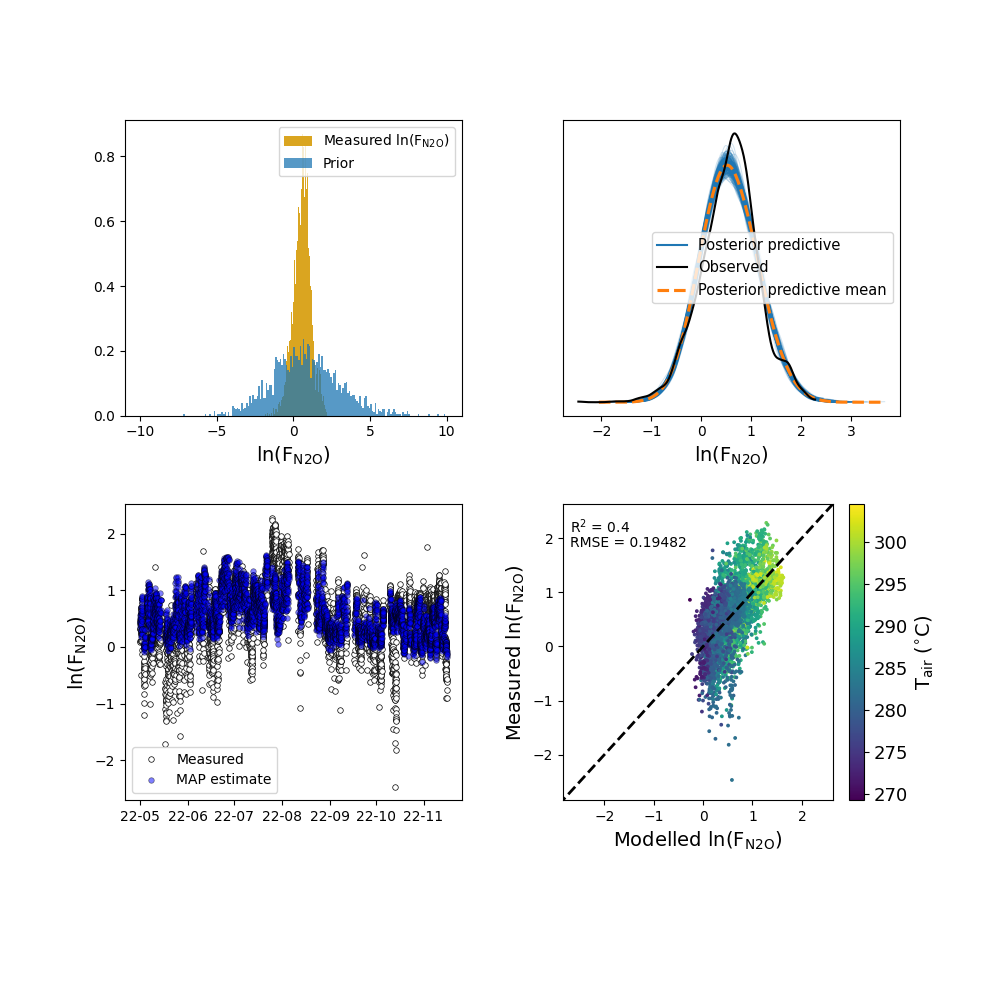

In [37]:
model = full_model_eq(full_n2o_st4['T_air'].eval(), st_4_n2o.values, map_estimate_st4, np.arange(data_n2o.shape[0]))
obs = data_n2o.loc[:, 'F_N2O_ln']

prior = idata_full_n2o_st4['prior']
data_inds = np.random.choice(st_5_n2o.shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = full_model_eq(full_n2o_st4['T_air'].eval(), st_4_n2o.values, pp, data_inds)

posterior = full_n2o_st4_res

xlabel = 'ln(F$_{\mathrm{N2O}}$)'
ylabel = 'ln(F$_{\mathrm{N2O}}$)'

color_var = data_n2o.T_air_K.values
cb_label = 'T$_{\mathrm{air}}$ (K)'

visualize_fit(model, obs, prior_values, posterior, xlabel, ylabel, color_var=color_var, cb_label=cb_label, axs=None)

In [38]:
fname = 'models/full_model_n2o_st4_mutable.pkl'
dict_to_save = {'model': full_n2o_st4,
                'idata': idata_full_n2o_st4,
                'model_res': full_n2o_st4_res,
                'map': map_estimate_st4,
                'data': data_n2o
                }

with open(fname, 'wb') as buff:
    cloudpickle.dump(dict_to_save, buff)

### 5 surface types

In [39]:
full_n2o_st5, idata_full_n2o_st5 = full_model(T=data_n2o.T_air.values, X=st_5_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std)

Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]


In [40]:
full_n2o_st5_res = fit_model(full_n2o_st5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma_mu, gamma, delta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 789 seconds.


In [41]:
with full_n2o_st5:
        map_estimate_st5, optresult = pm.find_MAP(method="L-BFGS-B", return_raw=True
    )

In [42]:
with full_n2o_st5:
    pm.sample_posterior_predictive(full_n2o_st5_res, extend_inferencedata=True)

Sampling: [obs]


/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


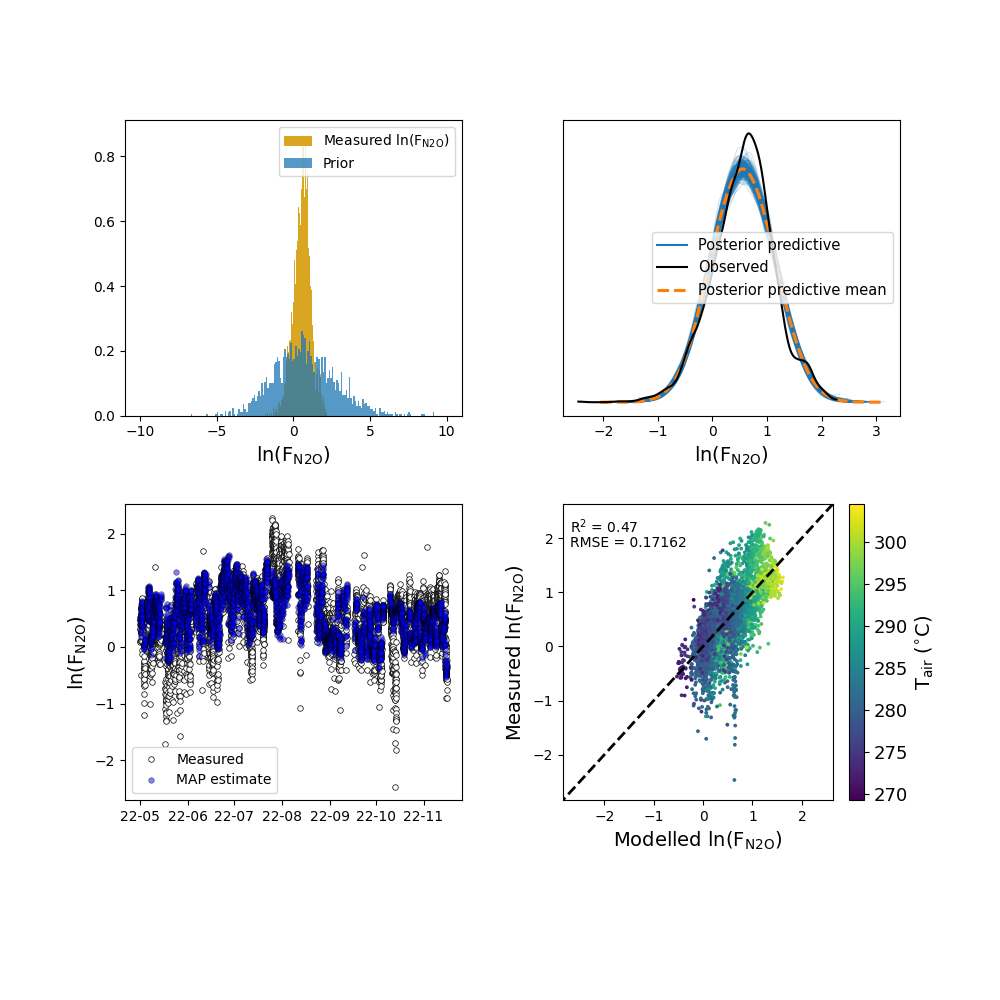

In [43]:
model = full_model_eq(full_n2o_st5['T_air'].eval(), st_5_n2o.values, map_estimate_st5, np.arange(data_n2o.shape[0]))
obs = data_n2o.loc[:, 'F_N2O_ln']

prior = idata_full_n2o_st5['prior']
data_inds = np.random.choice(st_5_n2o.shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = full_model_eq(full_n2o_st5['T_air'].eval(), st_5_n2o.values, pp, data_inds)

posterior = full_n2o_st5_res

xlabel = 'ln(F$_{\mathrm{N2O}}$)'
ylabel = 'ln(F$_{\mathrm{N2O}}$)'

color_var = data_n2o.T_air_K.values
cb_label = 'T$_{\mathrm{air}}$ (K)'

visualize_fit(model, obs, prior_values, posterior, xlabel, ylabel, color_var=color_var, cb_label=cb_label, axs=None)

In [44]:
fname = 'models/full_model_n2o_st5_mutable.pkl'
dict_to_save = {'model': full_n2o_st5,
                'idata': idata_full_n2o_st5,
                'model_res': full_n2o_st5_res,
                'map': map_estimate_st5,
                'data': data_n2o
                }

with open(fname, 'wb') as buff:
    cloudpickle.dump(dict_to_save, buff)

### 6 surface types

In [45]:
full_n2o_st6, idata_full_n2o_st6 = full_model(T=data_n2o.T_air.values, X=st_6_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std)

Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]


In [46]:
full_n2o_st6_res = fit_model(full_n2o_st6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma_mu, gamma, delta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 834 seconds.


In [47]:
with full_n2o_st6:
        map_estimate_st6, optresult = pm.find_MAP(method="L-BFGS-B", return_raw=True
    )

In [48]:
with full_n2o_st6:
    pm.sample_posterior_predictive(full_n2o_st6_res, extend_inferencedata=True)

Sampling: [obs]


/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


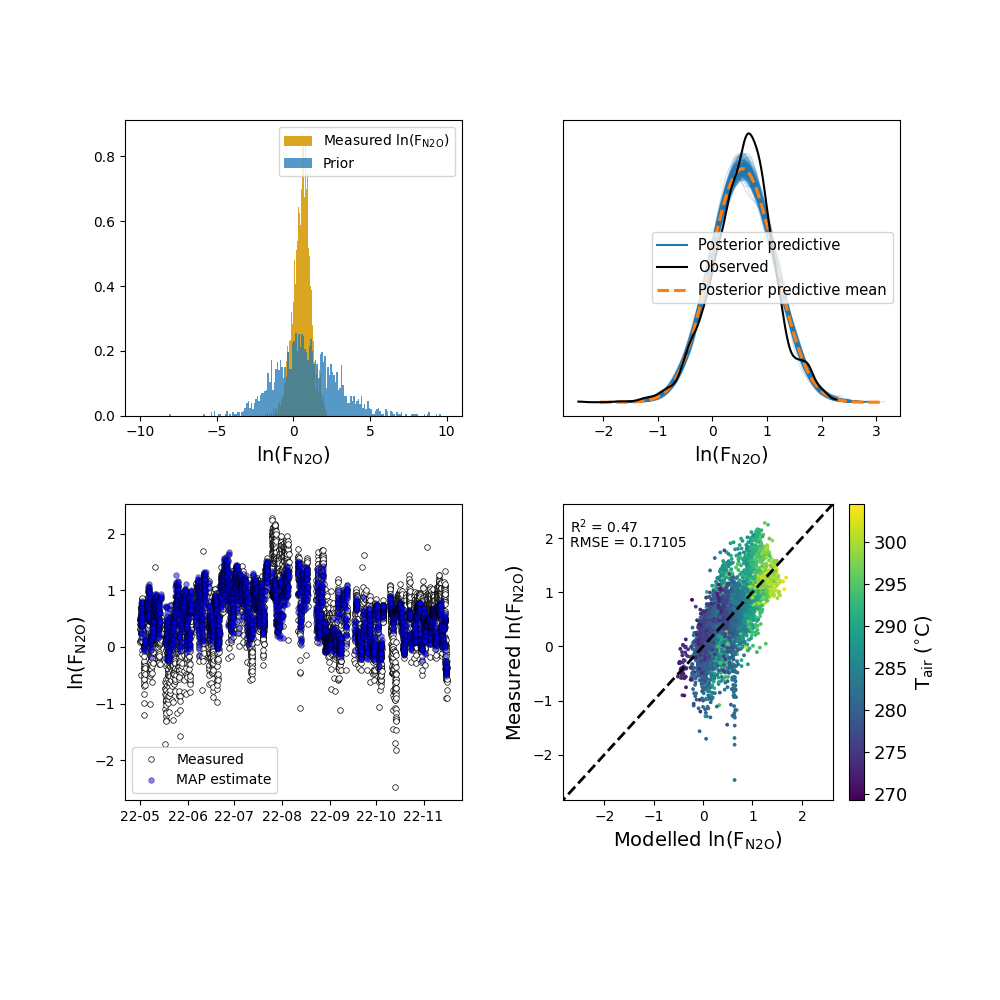

In [49]:
model = full_model_eq(full_n2o_st6['T_air'].eval(), st_6_n2o.values, map_estimate_st6, np.arange(data_n2o.shape[0]))
obs = data_n2o.loc[:, 'F_N2O_ln']

prior = idata_full_n2o_st6['prior']
data_inds = np.random.choice(st_5_n2o.shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = full_model_eq(full_n2o_st6['T_air'].eval(), st_6_n2o.values, pp, data_inds)

posterior = full_n2o_st6_res

xlabel = 'ln(F$_{\mathrm{N2O}}$)'
ylabel = 'ln(F$_{\mathrm{N2O}}$)'

color_var = data_n2o.T_air_K.values
cb_label = 'T$_{\mathrm{air}}$ (K)'

visualize_fit(model, obs, prior_values, posterior, xlabel, ylabel, color_var=color_var, cb_label=cb_label, axs=None)

In [50]:
fname = 'models/full_model_n2o_st6_mutable.pkl'
dict_to_save = {'model': full_n2o_st6,
                'idata': idata_full_n2o_st6,
                'model_res': full_n2o_st6_res,
                'map': map_estimate_st6,
                'data': data_n2o
                }

with open(fname, 'wb') as buff:
    cloudpickle.dump(dict_to_save, buff)

### 9 Surface types

In [51]:
full_n2o_st9, idata_full_n2o_st9 = full_model(T=data_n2o.T_air.values, X=st_9_n2o, y = data_n2o.F_N2O_ln.values, alpha_mu_mean=n2o_tenC_mean, alpha_mu_std=n2o_tenC_std)

Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]


In [52]:
full_n2o_st9_res = fit_model(full_n2o_st9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma_mu, gamma, delta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1094 seconds.


In [53]:
with full_n2o_st9:
        map_estimate_st9, optresult = pm.find_MAP(method="L-BFGS-B", return_raw=True
    )

In [54]:
with full_n2o_st9:
    pm.sample_posterior_predictive(full_n2o_st9_res, extend_inferencedata=True)

Sampling: [obs]


/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


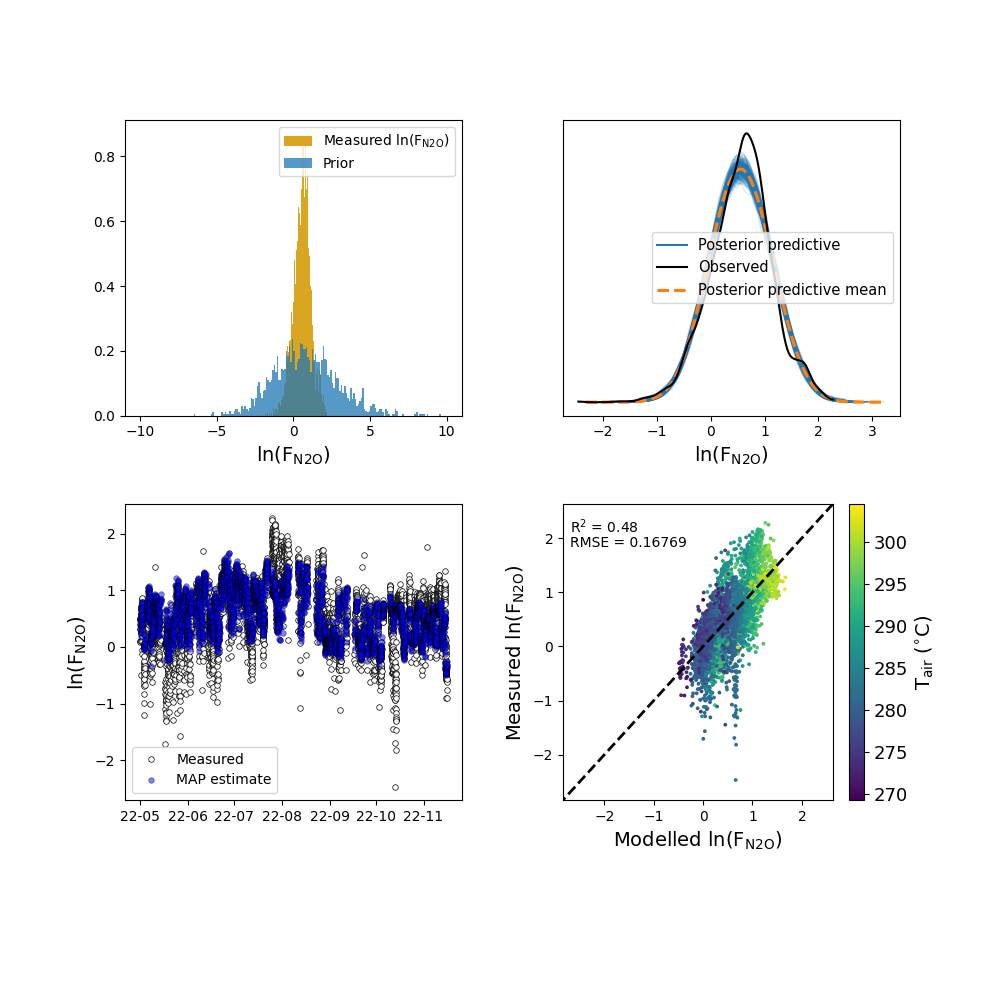

In [55]:
model = full_model_eq(full_n2o_st9['T_air'].eval(), st_9_n2o.values, map_estimate_st9, np.arange(data_n2o.shape[0]))
obs = data_n2o.loc[:, 'F_N2O_ln']

prior = idata_full_n2o_st9['prior']
data_inds = np.random.choice(st_9_n2o.shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = full_model_eq(full_n2o_st9['T_air'].eval(), st_9_n2o.values, pp, data_inds)

posterior = full_n2o_st9_res

xlabel = 'ln(F$_{\mathrm{N2O}}$)'
ylabel = 'ln(F$_{\mathrm{N2O}}$)'

color_var = data_n2o.T_air_K.values
cb_label = 'T$_{\mathrm{air}}$ (K)'

visualize_fit(model, obs, prior_values, posterior, xlabel, ylabel, color_var=color_var, cb_label=cb_label, axs=None)

In [56]:
fname = 'models/full_model_n2o_st9_mutable.pkl'
dict_to_save = {'model': full_n2o_st9,
                'idata': idata_full_n2o_st9,
                'model_res': full_n2o_st9_res,
                'map': map_estimate_st9,
                'data': data_n2o
                }

with open(fname, 'wb') as buff:
    cloudpickle.dump(dict_to_save, buff)

# CH<sub>4</sub> models

## $\alpha$ prior parameters

In [60]:
ind = ((data_ch4.T_air <= 11) & (data_ch4.T_air >= 9))
ch4_tenC_mean, ch4_tenC_std = ((data_ch4.loc[ind, 'F_CH4_ln']).mean(), (data_ch4.loc[ind, 'F_CH4_ln']).std())

## CH<sub>4</sub> simple model

In [61]:
simple_ch4, idata_simple_ch4 = simple_model(T=data_ch4.T_air.values, y=data_ch4.F_CH4_ln.values, alpha_mean=ch4_tenC_mean, alpha_std=ch4_tenC_std)

Sampling: [alpha, beta, obs, sigma]


In [62]:
simple_ch4_res = fit_model(simple_ch4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 35 seconds.


In [63]:
with simple_ch4:
        map_estimate_simple, optresult = pm.find_MAP(method="L-BFGS-B", return_raw=True
    )

In [64]:
with simple_ch4:
    pm.sample_posterior_predictive(simple_ch4_res, extend_inferencedata=True)

Sampling: [obs]


In [65]:
simple_ch4.T_air.eval()

array([ 2.711 ,  3.7231,  4.9192, ..., -1.2595, -1.3767, -1.5496])

/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


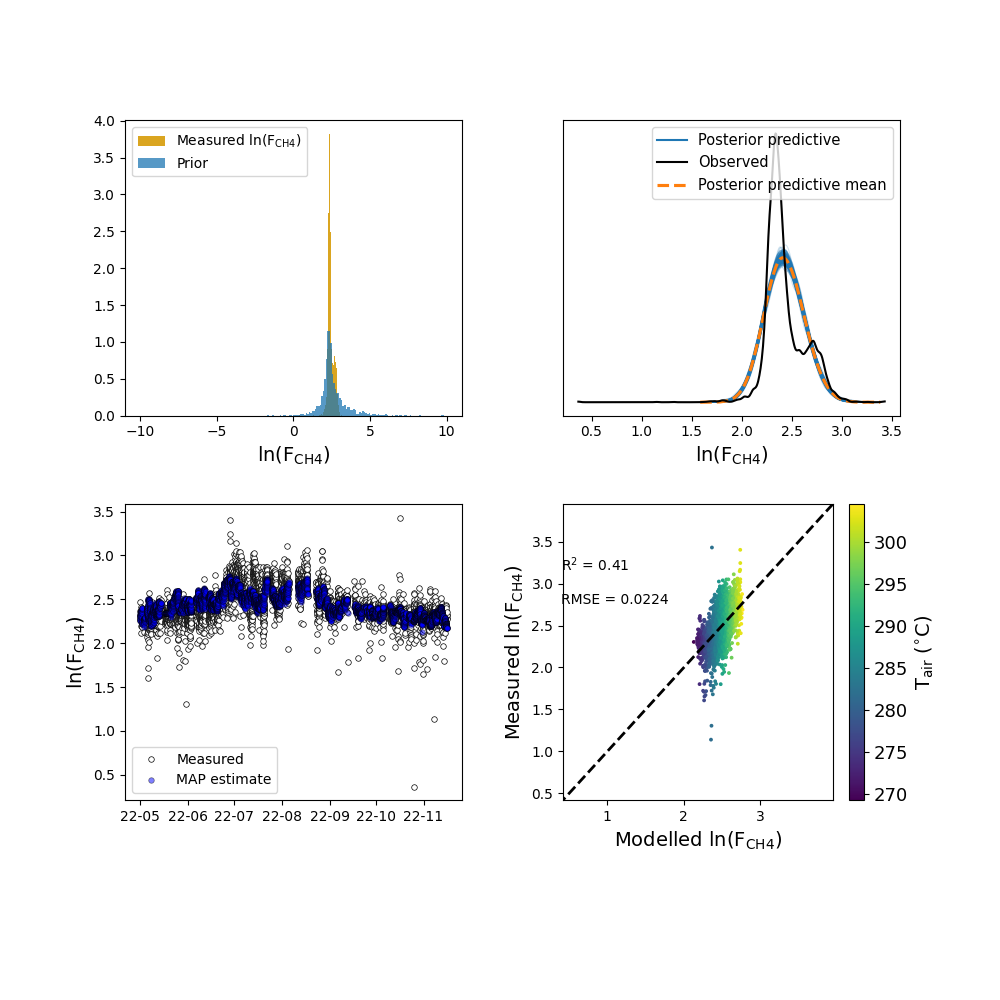

In [66]:
model = simple_model_eq(simple_ch4['T_air'].eval(), map_estimate_simple, np.arange(data_ch4.shape[0]))
obs = data_ch4.loc[:, 'F_CH4_ln']

prior = idata_simple_ch4['prior']
data_inds = np.random.choice(simple_ch4.T_air.eval().shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = simple_model_eq(simple_ch4['T_air'].eval(), pp, data_inds)

posterior = simple_ch4_res

xlabel = 'ln(F$_{\mathrm{CH4}}$)'
ylabel = 'ln(F$_{\mathrm{CH4}}$)'

color_var = data_ch4.T_air_K.values
cb_label = 'T$_{\mathrm{air}}$ (K)'

visualize_fit(model, obs, prior_values, posterior, xlabel, ylabel, color_var=color_var, cb_label=cb_label, axs=None)

In [67]:
fname = 'models/simple_model_ch4_mutable.pkl'
dict_to_save = {'model': simple_ch4,
                'idata': idata_simple_ch4,
                'model_res': simple_ch4_res,
                'map': map_estimate_simple,
                'data': data_ch4
                }

with open(fname, 'wb') as buff:
    cloudpickle.dump(dict_to_save, buff)

## CH<sub>4</sub> full model

### 3 surface types

In [68]:
full_ch4_st3, idata_full_ch4_st3 = full_model(T=data_ch4.T_air.values, X=st_3_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std)

Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]


In [69]:
full_ch4_st3_res = fit_model(full_ch4_st3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma_mu, gamma, delta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 536 seconds.


In [70]:
with full_ch4_st3:
        map_estimate_st3, optresult = pm.find_MAP(method="L-BFGS-B", return_raw=True
    )

In [71]:
with full_ch4_st3:
    pm.sample_posterior_predictive(full_ch4_st3_res, extend_inferencedata=True)

Sampling: [obs]


/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


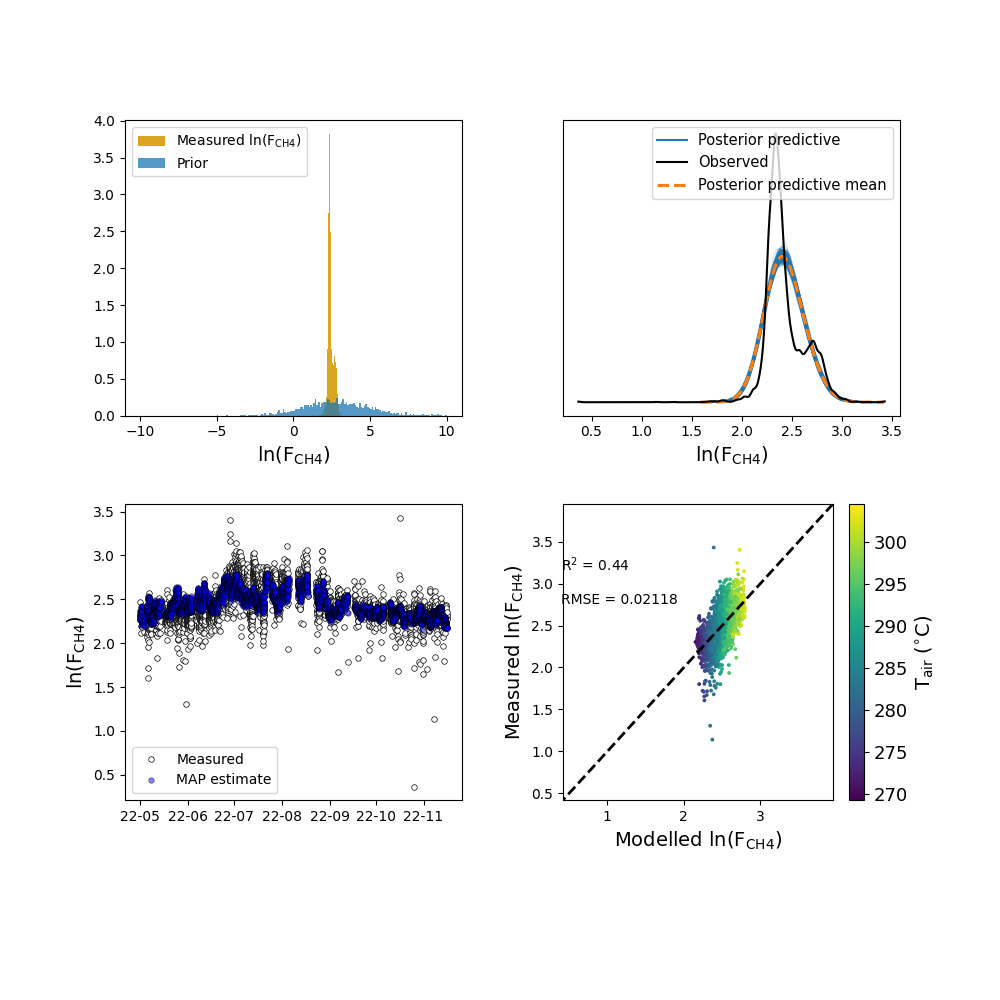

In [72]:
model = full_model_eq(full_ch4_st3['T_air'].eval(), st_3_ch4.values, map_estimate_st3, np.arange(data_ch4.shape[0]))
obs = data_ch4.loc[:, 'F_CH4_ln']

prior = idata_full_ch4_st3['prior']
data_inds = np.random.choice(st_3_ch4.shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = full_model_eq(full_ch4_st3['T_air'].eval(), st_3_ch4.values, pp, data_inds)

posterior = full_ch4_st3_res

xlabel = 'ln(F$_{\mathrm{CH4}}$)'
ylabel = 'ln(F$_{\mathrm{CH4}}$)'

color_var = data_ch4.T_air_K.values
cb_label = 'T$_{\mathrm{air}}$ (K)'

visualize_fit(model, obs, prior_values, posterior, xlabel, ylabel, color_var=color_var, cb_label=cb_label, axs=None)

In [73]:
fname = 'models/full_model_ch4_st3_mutable.pkl'
dict_to_save = {'model': full_ch4_st3,
                'idata': idata_full_ch4_st3,
                'model_res': full_ch4_st3_res,
                'map': map_estimate_st3,
                'data': data_ch4
                }

with open(fname, 'wb') as buff:
    cloudpickle.dump(dict_to_save, buff)

### 4 surface types

In [74]:
full_ch4_st4, idata_full_ch4_st4 = full_model(T=data_ch4.T_air.values, X=st_4_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std)

Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]


In [75]:
full_ch4_st4_res = fit_model(full_ch4_st4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma_mu, gamma, delta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 690 seconds.


In [76]:
with full_ch4_st4:
        map_estimate_st4, optresult = pm.find_MAP(method="L-BFGS-B", return_raw=True
    )

In [77]:
with full_ch4_st4:
    pm.sample_posterior_predictive(full_ch4_st4_res, extend_inferencedata=True)

Sampling: [obs]


/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


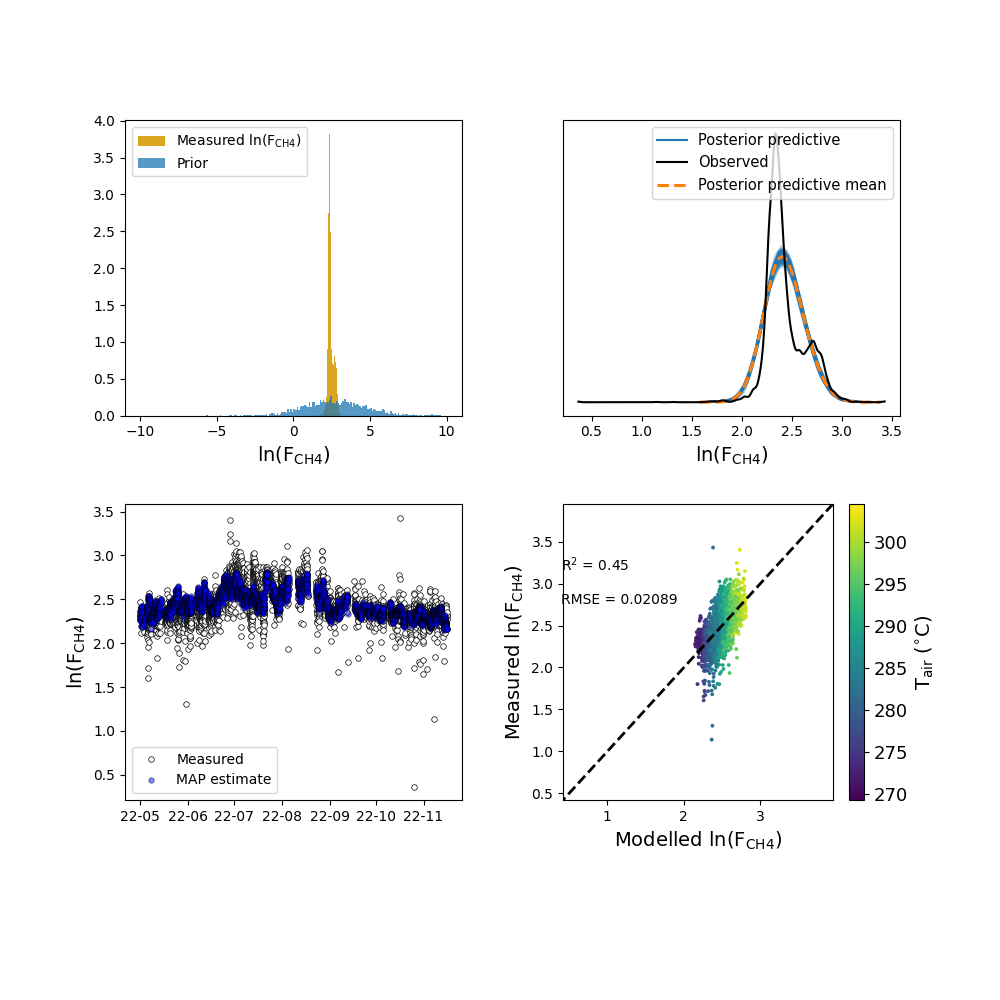

In [78]:
model = full_model_eq(full_ch4_st4['T_air'].eval(), st_4_ch4.values, map_estimate_st4, np.arange(data_ch4.shape[0]))
obs = data_ch4.loc[:, 'F_CH4_ln']

prior = idata_full_ch4_st4['prior']
data_inds = np.random.choice(st_3_ch4.shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = full_model_eq(full_ch4_st4['T_air'].eval(), st_4_ch4.values, pp, data_inds)

posterior = full_ch4_st4_res

xlabel = 'ln(F$_{\mathrm{CH4}}$)'
ylabel = 'ln(F$_{\mathrm{CH4}}$)'

color_var = data_ch4.T_air_K.values
cb_label = 'T$_{\mathrm{air}}$ (K)'

visualize_fit(model, obs, prior_values, posterior, xlabel, ylabel, color_var=color_var, cb_label=cb_label, axs=None)

In [79]:
fname = 'models/full_model_ch4_st4_mutable.pkl'
dict_to_save = {'model': full_ch4_st4,
                'idata': idata_full_ch4_st4,
                'model_res': full_ch4_st4_res,
                'map': map_estimate_st4,
                'data': data_ch4
                }

with open(fname, 'wb') as buff:
    cloudpickle.dump(dict_to_save, buff)

### 5 surface types

In [80]:
full_ch4_st5, idata_full_ch4_st5 = full_model(T=data_ch4.T_air.values, X=st_5_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std)

Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]


In [81]:
full_ch4_st5_res = fit_model(full_ch4_st5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma_mu, gamma, delta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 888 seconds.


In [82]:
with full_ch4_st5:
        map_estimate_st5, optresult = pm.find_MAP(method="L-BFGS-B", return_raw=True
    )

In [83]:
with full_ch4_st5:
    pm.sample_posterior_predictive(full_ch4_st5_res, extend_inferencedata=True)

Sampling: [obs]


/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


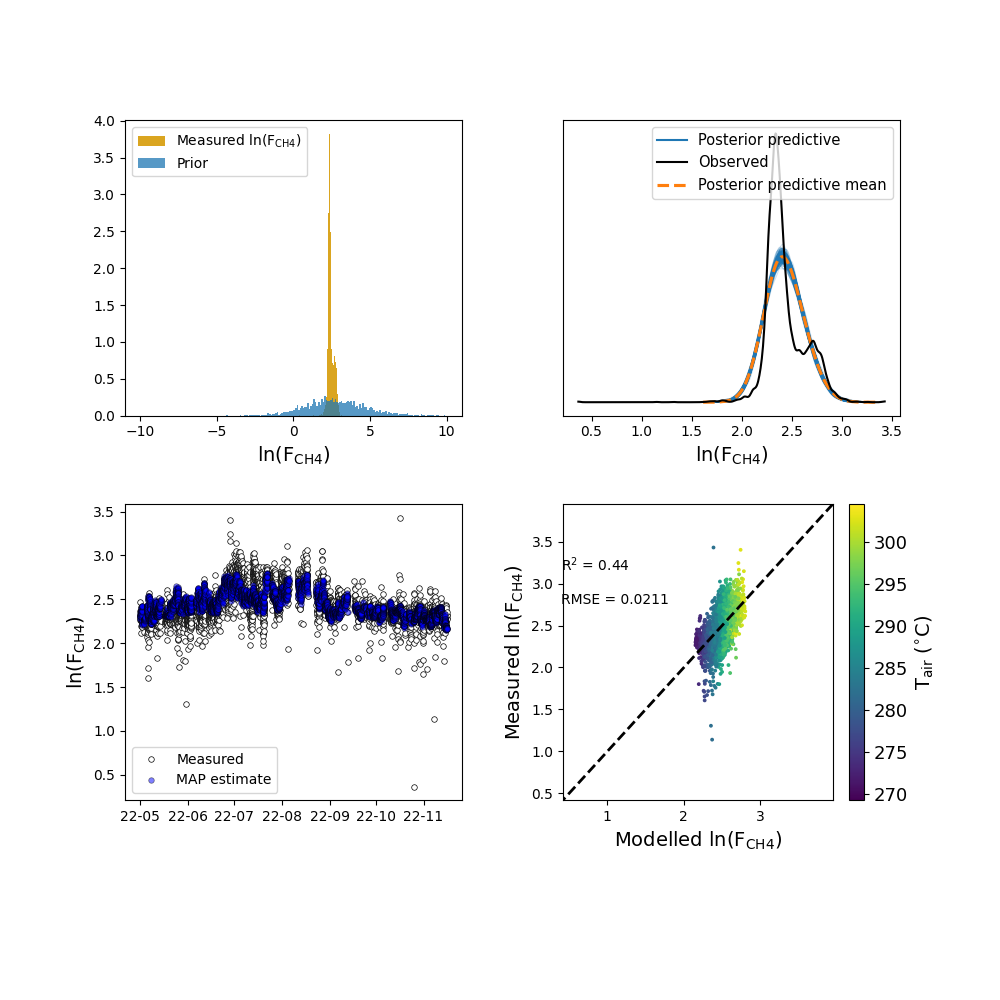

In [84]:
model = full_model_eq(full_ch4_st5['T_air'].eval(), st_5_ch4.values, map_estimate_st5, np.arange(data_ch4.shape[0]))
obs = data_ch4.loc[:, 'F_CH4_ln']

prior = idata_full_ch4_st5['prior']
data_inds = np.random.choice(st_5_ch4.shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = full_model_eq(full_ch4_st5['T_air'].eval(), st_5_ch4.values, pp, data_inds)

posterior = full_ch4_st5_res

xlabel = 'ln(F$_{\mathrm{CH4}}$)'
ylabel = 'ln(F$_{\mathrm{CH4}}$)'

color_var = data_ch4.T_air_K.values
cb_label = 'T$_{\mathrm{air}}$ (K)'

visualize_fit(model, obs, prior_values, posterior, xlabel, ylabel, color_var=color_var, cb_label=cb_label, axs=None)

In [85]:
fname = 'models/full_model_ch4_st5_mutable.pkl'
dict_to_save = {'model': full_ch4_st5,
                'idata': idata_full_ch4_st5,
                'model_res': full_ch4_st5_res,
                'map': map_estimate_st5,
                'data': data_ch4
                }

with open(fname, 'wb') as buff:
    cloudpickle.dump(dict_to_save, buff)

### 6 surface types

In [86]:
full_ch4_st6, idata_full_ch4_st6 = full_model(T=data_ch4.T_air.values, X=st_6_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std)

Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]


In [87]:
full_ch4_st6_res = fit_model(full_ch4_st6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma_mu, gamma, delta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 762 seconds.


In [88]:
with full_ch4_st6:
        map_estimate_st6, optresult = pm.find_MAP(method="L-BFGS-B", return_raw=True
    )

In [89]:
with full_ch4_st6:
    pm.sample_posterior_predictive(full_ch4_st6_res, extend_inferencedata=True)

Sampling: [obs]


/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


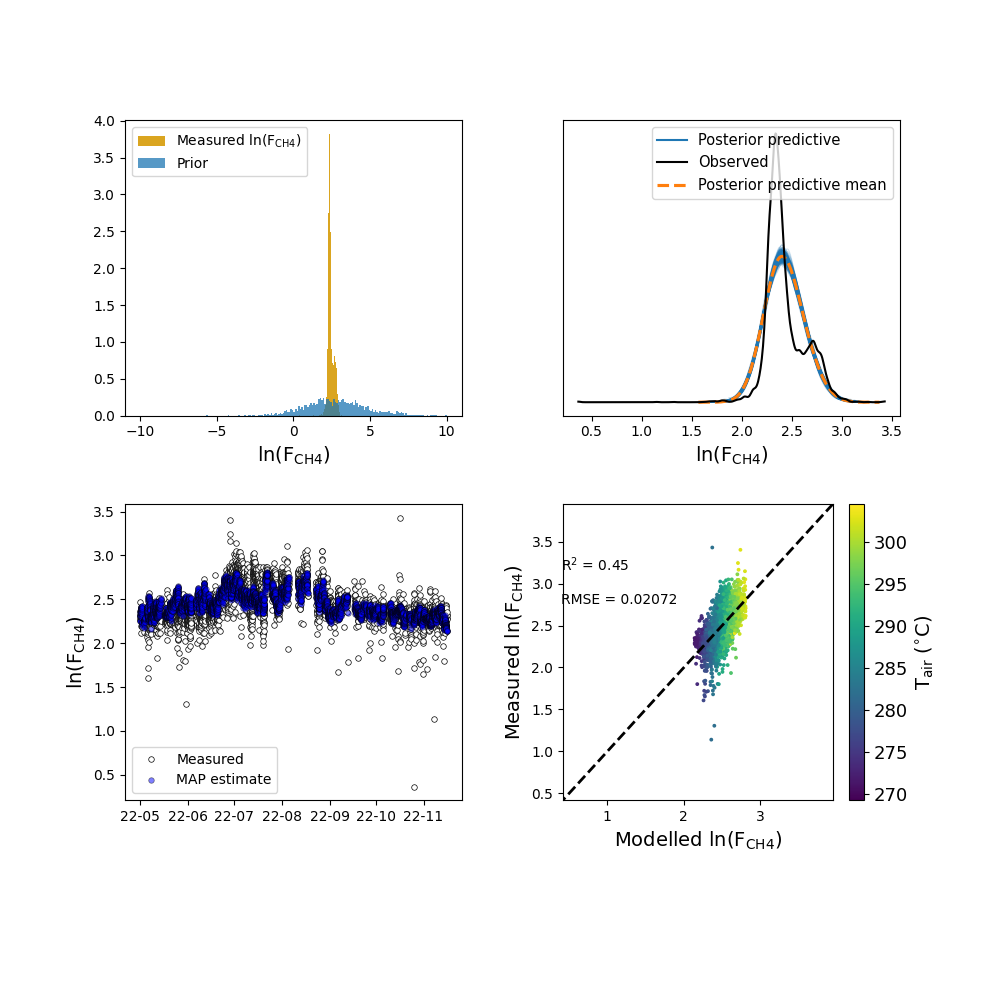

In [90]:
model = full_model_eq(full_ch4_st6['T_air'].eval(), st_6_ch4.values, map_estimate_st6, np.arange(data_ch4.shape[0]))
obs = data_ch4.loc[:, 'F_CH4_ln']

prior = idata_full_ch4_st6['prior']
data_inds = np.random.choice(st_3_ch4.shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = full_model_eq(full_ch4_st6['T_air'].eval(), st_6_ch4.values, pp, data_inds)

posterior = full_ch4_st6_res

xlabel = 'ln(F$_{\mathrm{CH4}}$)'
ylabel = 'ln(F$_{\mathrm{CH4}}$)'

color_var = data_ch4.T_air_K.values
cb_label = 'T$_{\mathrm{air}}$ (K)'

visualize_fit(model, obs, prior_values, posterior, xlabel, ylabel, color_var=color_var, cb_label=cb_label, axs=None)

In [91]:
fname = 'models/full_model_ch4_st6_mutable.pkl'
dict_to_save = {'model': full_ch4_st6,
                'idata': idata_full_ch4_st6,
                'model_res': full_ch4_st6_res,
                'map': map_estimate_st6,
                'data': data_ch4
                }

with open(fname, 'wb') as buff:
    cloudpickle.dump(dict_to_save, buff)

### 9 Surface types

In [92]:
full_ch4_st9, idata_full_ch4_st9 = full_model(T=data_ch4.T_air.values, X=st_9_ch4, y = data_ch4.F_CH4_ln.values, alpha_mu_mean=ch4_tenC_mean, alpha_mu_std=ch4_tenC_std)

Sampling: [alpha, beta, delta, gamma, gamma_mu, obs, sigma]


In [93]:
full_ch4_st9_res = fit_model(full_ch4_st9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma_mu, gamma, delta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1034 seconds.


In [94]:
with full_ch4_st9:
        map_estimate_st9, optresult = pm.find_MAP(method="L-BFGS-B", return_raw=True
    )

In [95]:
with full_ch4_st9:
    pm.sample_posterior_predictive(full_ch4_st9_res, extend_inferencedata=True)

Sampling: [obs]


/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


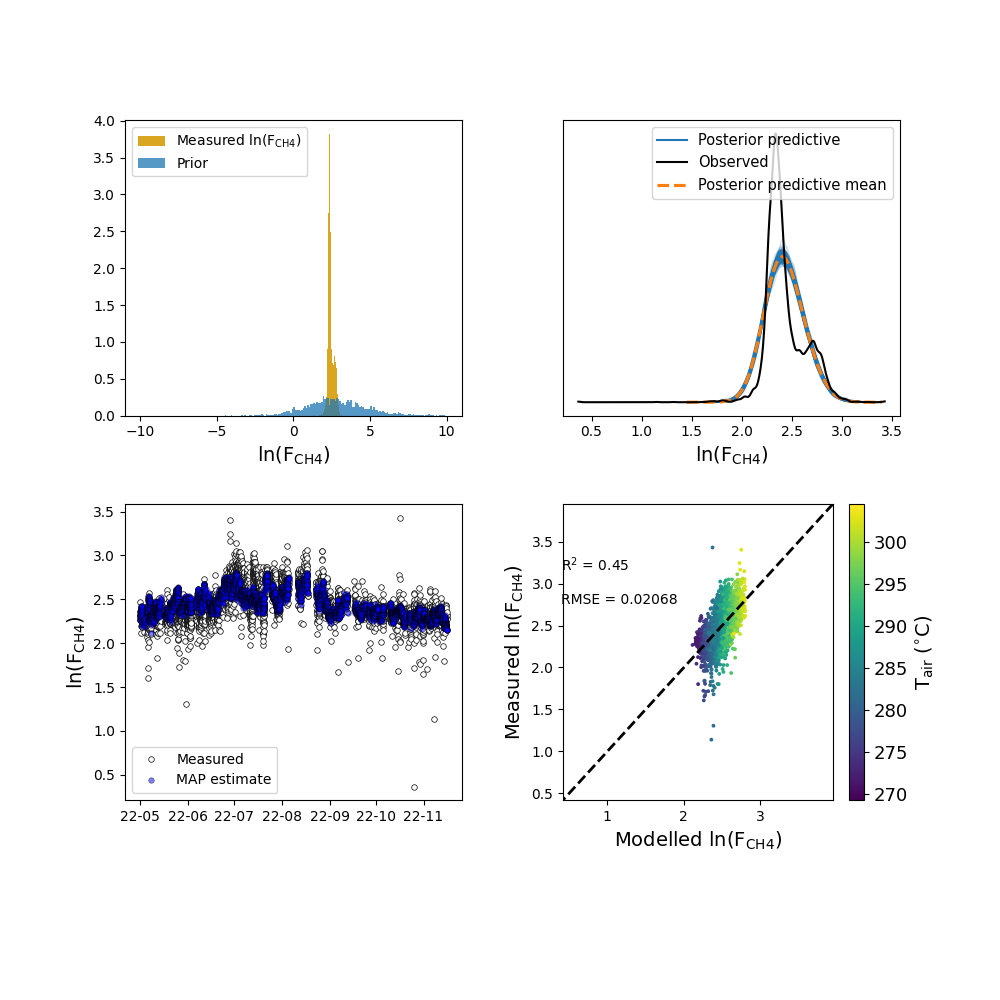

In [96]:
model = full_model_eq(full_ch4_st9['T_air'].eval(), st_9_ch4.values, map_estimate_st9, np.arange(data_ch4.shape[0]))
obs = data_ch4.loc[:, 'F_CH4_ln']

prior = idata_full_ch4_st9['prior']
data_inds = np.random.choice(st_9_ch4.shape[0], size=2000)
pp = {k:np.squeeze(v.to_numpy()) for k,v in prior.items()}
prior_values = full_model_eq(full_ch4_st9['T_air'].eval(), st_9_ch4.values, pp, data_inds)

posterior = full_ch4_st9_res

xlabel = 'ln(F$_{\mathrm{CH4}}$)'
ylabel = 'ln(F$_{\mathrm{CH4}}$)'

color_var = data_ch4.T_air_K.values
cb_label = 'T$_{\mathrm{air}}$ (K)'

visualize_fit(model, obs, prior_values, posterior, xlabel, ylabel, color_var=color_var, cb_label=cb_label, axs=None)

In [97]:
fname = 'models/full_model_ch4_st9_mutable.pkl'
dict_to_save = {'model': full_ch4_st9,
                'idata': idata_full_ch4_st9,
                'model_res': full_ch4_st9_res,
                'map': map_estimate_st9,
                'data': data_ch4
                }

with open(fname, 'wb') as buff:
    cloudpickle.dump(dict_to_save, buff)